## ETL

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display


In [3]:
# Load the labeled data
good_examples = pd.read_csv('./InDaS Labeled/good_period_2024_01_03.csv')
good_examples

bad_examples = pd.read_csv('./InDaS Labeled/bad_period_2024_01_06.csv')
bad_examples

all_good_segments = []
all_bad_segments = []

In [4]:
# Apply the indicator function to create a new column
good_examples['indicator'] = good_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_good = good_examples.index[good_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_good.append(len(good_examples))


# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_good)-1):
    good_segment = good_examples.iloc[start_indices_good[i]:start_indices_good[i + 1]]
    all_good_segments.append(good_segment)

print("Total Good Cutting Data:", len(all_good_segments))
print("Shape of Segment 1:", all_good_segments[0].shape)
print("Shape of Torque Data:", all_good_segments[0]['Torque'].shape)


Total Good Cutting Data: 4552
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


In [5]:
# Apply the indicator function to create a new column
bad_examples['indicator'] = bad_examples.apply(lambda x: 1 if x['rel_time'] == 0 else 0, axis=1)

start_indices_bad = bad_examples.index[bad_examples['indicator'] == 1].tolist()

# Add the end of the DataFrame as the last index
start_indices_bad.append(len(bad_examples))

# Loop through each segment and plot, limiting the number of rotations
for i in range(len(start_indices_bad)-1):
    segment = bad_examples.iloc[start_indices_bad[i]:start_indices_bad[i + 1]]
    all_bad_segments.append(segment)

print("Total Bad Cutting Data:", len(all_bad_segments))
print("Shape of Segment 1:", all_bad_segments[0].shape)
print("Shape of Torque Data:", all_bad_segments[0]['Torque'].shape)


Total Bad Cutting Data: 1937
Shape of Segment 1: (1668, 11)
Shape of Torque Data: (1668,)


In [6]:
# Bad Samples
bad_onramps = list()
bad_cuttings = list()
bad_cleanings = list()
bad_offramps = list()
for i in range(len(all_bad_segments)):
    bad_onramp_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] >= 0.0) & (all_bad_segments[i]['rel_time'] <= 0.50)]
    bad_cutting_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] > 0.50) & (all_bad_segments[i]['rel_time'] <= 1.60)]
    bad_cleaning_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] > 1.60) & (all_bad_segments[i]['rel_time'] <= 3.0)]
    bad_offramp_segment = all_bad_segments[i].loc[(all_bad_segments[i]['rel_time'] > 3.0) & (all_bad_segments[i]['rel_time'] <= 3.5)]

    # Append the segments to the lists
    bad_onramps.append(bad_onramp_segment)
    bad_cuttings.append(bad_cutting_segment)
    bad_cleanings.append(bad_cleaning_segment)
    bad_offramps.append(bad_offramp_segment)

In [7]:
# Good Samples
good_onramps = list()
good_cuttings = list()
good_cleanings = list()
good_offramps = list()
# Good Samples
for i in range(len(all_good_segments)):
    good_onramp_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] >= 0.0) & (all_good_segments[i]['rel_time'] <= 0.50)]
    good_cutting_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] > 0.50) & (all_good_segments[i]['rel_time'] <= 1.60)]
    good_cleaning_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] > 1.60) & (all_good_segments[i]['rel_time'] <= 3.0)]
    good_offramp_segment = all_good_segments[i].loc[(all_good_segments[i]['rel_time'] > 3.0) & (all_good_segments[i]['rel_time'] <= 3.5)]

    good_onramps.append(good_onramp_segment)
    good_cuttings.append(good_cutting_segment)
    good_cleanings.append(good_cleaning_segment)
    good_offramps.append(good_offramp_segment)    


## Convert Time-Series into Spectogram Features

In [8]:
import pywt
import cv2

good_scalo_features = list()
bad_scalo_features = list()

#scale_resolution = 512
scale_resolution = 24


def compute_scalo_spectrogram(data, title, wavelet='cmor', cmap='magma'):
    #scales = np.linspace(1, scale_resolution, 16)
    scales = np.arange(1, scale_resolution)
    coefficients, frequencies = pywt.cwt(data, scales, wavelet)
    power = (abs(coefficients)) ** 2

    return power



# Sample number
MAX_SAMPLES_GOOD = 4552
# Sample number
MAX_SAMPLES_BAD = 1936

window = 836

for i in range(MAX_SAMPLES_GOOD):
    
    good_cutting_torque = np.asarray(all_good_segments[i]['Torque'])
    good_scalo = compute_scalo_spectrogram(good_cutting_torque, 'good cutting segment')
    # Cut the x axis of good_scalo to 512 (!try extending to 545)
    good_scalo = good_scalo[:, :window]

    #print(good_scalo.shape)
    # Normalize as images
    good_scalo = cv2.normalize(good_scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    good_scalo_features.append(good_scalo)
    
for i in range(MAX_SAMPLES_BAD):
    bad_cutting_torque = np.asarray(all_bad_segments[i]['Torque'])
    bad_scalo = compute_scalo_spectrogram(bad_cutting_torque, 'bad cutting segment')
    bad_scalo = bad_scalo[:, :window]

    #print(bad_scalo.shape)
    # Normalize as images
    bad_scalo = cv2.normalize(bad_scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)
    
    bad_scalo_features.append(bad_scalo)

print("shape of good scalo features", good_scalo_features[0].shape)
print("total scalo features", len(good_scalo_features))

# 256 7m11.2s
# 128 1m 54.9s
# 32 11.5s
# 24 8.1s
print(bad_scalo_features[0])

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


shape of good scalo features (23, 836)
total scalo features 4552
[[8.8881300e-04 4.2146519e-05 4.7471956e-05 ... 4.3360022e-04
  1.6988367e-04 5.6527928e-04]
 [2.9870404e-03 6.8463868e-04 4.0552780e-04 ... 5.2258214e-03
  4.7977343e-03 2.7072460e-03]
 [9.0097347e-03 4.5242240e-03 1.3491983e-03 ... 2.1282362e-02
  1.6520841e-02 9.8337121e-03]
 ...
 [2.4465723e-01 1.2327657e-01 4.9570832e-02 ... 5.5898339e-03
  6.3899015e-03 8.2800603e-03]
 [2.4041027e-01 2.7600983e-01 2.3958187e-01 ... 6.7054415e-03
  6.5323985e-03 7.7841021e-03]
 [3.8652819e-01 4.0082255e-01 2.0596235e-01 ... 8.7189460e-03
  8.5737798e-03 6.0067177e-03]]


## Plot the feature to the CNN Input

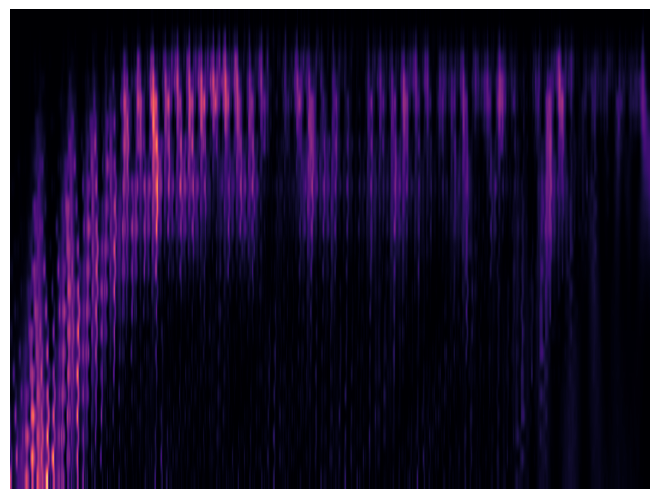

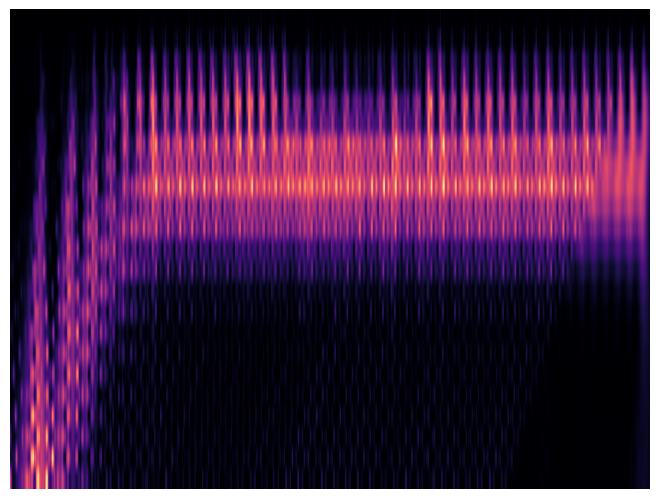

In [9]:
# Which Sample to View
S = 100
cmap = 'magma'
# Example to view one scalogram as an image using OpenCV
temp = np.asarray(bad_scalo_features[S])

# Normalize the data to 0-255 for display
temp_normalized = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
temp_normalized = temp_normalized.astype(np.uint8)
# image as inferno
#temp_normalized = cv2.applyColorMap(temp_normalized, cv2.COLORMAP_INFERNO)

# # Display the image
# cv2.imshow('Scalogram', temp_normalized)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# # View as Plt

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp_normalized, cmap, aspect='auto')
plt.show()


# Example to view one scalogram as an image using OpenCV
temp = np.asarray(good_scalo_features[S])

# Normalize the data to 0-255 for display
temp_normalized = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
temp_normalized = temp_normalized.astype(np.uint8)
# image as inferno
#temp_normalized = cv2.applyColorMap(temp_normalized, cv2.COLORMAP_INFERNO)

# # Display the image
# cv2.imshow('Scalogram', temp_normalized)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# # View as Plt

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp_normalized, cmap, aspect='auto')
plt.show()

## Undersample Classes to Balance Them

### Scalo Features

In [10]:

SAMPLES_FOR_TRAINING = 1800
balanced_good_scalo_features = np.array(good_scalo_features[:SAMPLES_FOR_TRAINING])
balanced_bad_scalo_features = np.array(bad_scalo_features[:SAMPLES_FOR_TRAINING])

validation_good_scalo_features = np.array(good_scalo_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_GOOD])
validation_bad_scalo_features = np.array(bad_scalo_features[SAMPLES_FOR_TRAINING:MAX_SAMPLES_BAD])

validation_good_scalo_labels = np.ones(validation_good_scalo_features.shape[0])
validation_bad_scalo_labels = np.zeros(validation_bad_scalo_features.shape[0])

validation_scalo_features = np.concatenate((validation_good_scalo_features, validation_bad_scalo_features), axis=0)
validation_scalo_labels = np.concatenate((validation_good_scalo_labels, validation_bad_scalo_labels), axis=0)
print("scalo Features Val Shape:", validation_scalo_features.shape)
print("Balanced_Good", balanced_good_scalo_features.shape)
print("Balanced_Bad", balanced_bad_scalo_features.shape)

scalo Features Val Shape: (2888, 23, 836)
Balanced_Good (1800, 23, 836)
Balanced_Bad (1800, 23, 836)


# Experimental CNN 

## Train-Test Split

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from sklearn.model_selection import train_test_split

# Convert your features to numpy arrays if they're not already
good_scalo_features = np.array(good_scalo_features)
bad_scalo_features = np.array(bad_scalo_features)

# Create labels
good_labels = np.ones(len(good_scalo_features))
bad_labels = np.zeros(len(bad_scalo_features))

# Combine features and labels
X = np.concatenate((good_scalo_features, bad_scalo_features), axis=0)
y = np.concatenate((good_labels, bad_labels))

TEST_SIZE = 0.4
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

## Dataloader

In [12]:
class ScalogramDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        
        # Expand dimensions to create a 3-channel image
        feature = np.expand_dims(feature, axis=0)
        feature = np.repeat(feature, 3, axis=0)
       
        return torch.FloatTensor(feature), torch.FloatTensor([label])

# Create datasets and dataloaders
train_dataset = ScalogramDataset(X_train, y_train)
test_dataset = ScalogramDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### ResNet50 BIG MISTAKE YOU ARE NOT USING SINGLE CHANNEL

In [13]:
class ModifiedResNet50(nn.Module):
    def __init__(self):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(weights=None)
        
        # Modify the first convolutional layer to accept 1-channel input
        self.resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Modify the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.resnet(x))

# Initialize the model
model = ModifiedResNet50()


In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
learning_rate = 1e-05
weight_decay = 1e-04

# Use Binary Cross Entropy Loss if you want to generate a probability as output
criterion = nn.BCELoss()
# Use Cross Entropy Loss if you want to generate a class as output
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Define the learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training & Validation Loop

Epoch 1/10
Train Loss: 0.2390, Train Acc: 0.9304
Test Loss: 0.0941, Test Acc: 0.9831

Epoch 2/10
Train Loss: 0.0669, Train Acc: 0.9789
Test Loss: 0.0315, Test Acc: 0.9946

Epoch 3/10
Train Loss: 0.0351, Train Acc: 0.9910
Test Loss: 0.0224, Test Acc: 0.9977

Epoch 4/10
Train Loss: 0.0180, Train Acc: 0.9961
Test Loss: 0.0135, Test Acc: 0.9977

Epoch 5/10
Train Loss: 0.0098, Train Acc: 0.9985
Test Loss: 0.0127, Test Acc: 0.9969

Epoch 6/10
Train Loss: 0.0078, Train Acc: 0.9987
Test Loss: 0.0117, Test Acc: 0.9977

Epoch 7/10
Train Loss: 0.0054, Train Acc: 0.9995
Test Loss: 0.0116, Test Acc: 0.9977

Epoch 8/10
Train Loss: 0.0033, Train Acc: 0.9997
Test Loss: 0.0090, Test Acc: 0.9985

Epoch 9/10
Train Loss: 0.0013, Train Acc: 1.0000
Test Loss: 0.0093, Test Acc: 0.9981

Epoch 10/10
Train Loss: 0.0027, Train Acc: 0.9995
Test Loss: 0.0413, Test Acc: 0.9981



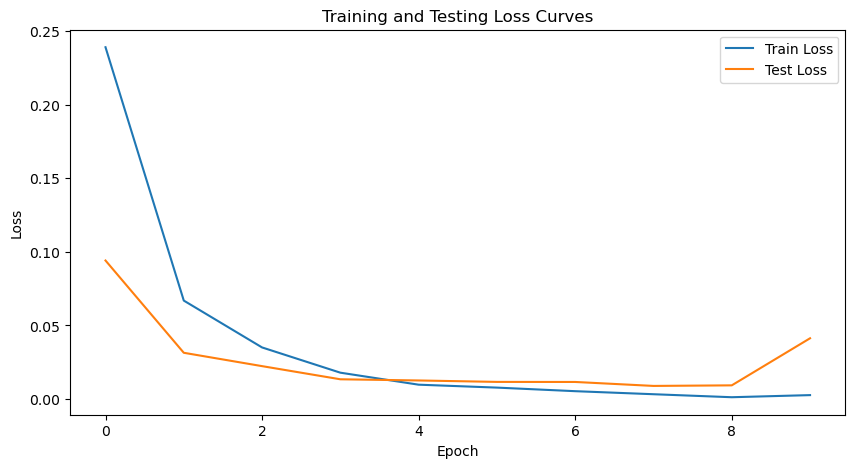

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for features, labels in loader:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for features, labels in loader:
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Training loop
num_epochs = 10
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print()
    # Step the scheduler
    scheduler.step(test_loss)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Curves')
plt.legend()
plt.show()

## Validation on Unseen Data

In [16]:
# Convert the validation features and labels to numpy arrays if they are not already
validation_scalo_features = np.array(validation_scalo_features)
validation_scalo_labels = np.array(validation_scalo_labels)

# Create dataset and dataloader for validation data
validation_dataset = ScalogramDataset(validation_scalo_features, validation_scalo_labels)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

Validation Loss: 0.0012
Validation Accuracy: 0.9993
Validation Precision: 1.0000
Validation Recall: 0.9993
Validation F1 Score: 0.9996


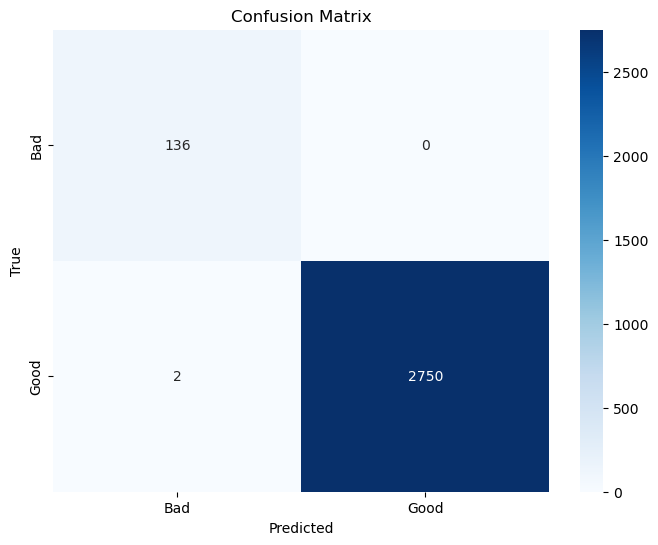

In [17]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Assuming your model and data preparation code is already here...

class ScalogramDataset(Dataset):
    def __init__(self, features, labels=None):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        
        # Expand dimensions to create a 3-channel image
        feature = np.expand_dims(feature, axis=0)
        feature = np.repeat(feature, 3, axis=0)
        
        if self.labels is not None:
            label = self.labels[idx]
            return torch.FloatTensor(feature), torch.FloatTensor([label])
        else:
            return torch.FloatTensor(feature)

# Convert the validation features and labels to numpy arrays if they are not already
validation_scalo_features = np.array(validation_scalo_features)
validation_scalo_labels = np.array(validation_scalo_labels)

# Create dataset and dataloader for validation data
validation_dataset = ScalogramDataset(validation_scalo_features, validation_scalo_labels)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)
all_labels = []
all_predictions = []

# Define the evaluation function
def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0

    
    with torch.no_grad():
        for features, labels in loader:
            #print(features.shape)
            features, labels = features.to(device), labels.to(device)
            
            outputs = model(features)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs > 0.5).float()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    epoch_loss = running_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    
    return epoch_loss, accuracy, precision, recall, f1


model.to(device)

# Define the loss criterion
criterion = nn.BCELoss()

# Run evaluation on the validation data
val_loss, val_accuracy, val_precision, val_recall, val_f1 = evaluate(model, validation_loader, criterion)

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Load Unlabelled Data

In [18]:
import json
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 4000
df = pd.read_csv('all.csv', nrows=nr_rows)
#print(df.head())
# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

torque_array = []
whole_rotation = []
first_rotation = []
second_rotation = []

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque = torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2 = resultat2.reset_index()

    resultat = resultat.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    resultat2 = resultat2.drop(columns=["Time", "index", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure both dataframes have the same shape by truncating or padding
    whole_len = 1800
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)


    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    total_data = total_data.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    total_data = total_data.head(max_len).reindex(range(whole_len), fill_value=0)
    whole_rotation.append(total_data)

    torque_array.append(torque)

# First Rotation
data = np.array(first_rotation)
squeezed_arr = np.squeeze(data)

# # Second Rotation - The rotatiion where Frequencies are different
# data2 = np.array(second_rotation)
# squeezed_arr2 = np.squeeze(data2)

# # Whole Rotation
# data3 = np.array(whole_rotation)
# whole_rotation_arr = np.squeeze(data3)

## Computing Scalograms

In [19]:
import pywt
import cv2

scalogram_features = list()
scale_resolution = 24

def compute_scalo_spectrogram(data, title, wavelet='cmor', cmap='magma'):
    scales = np.arange(1, scale_resolution)
    coefficients, frequencies = pywt.cwt(data, scales, wavelet)
    power = (abs(coefficients)) ** 2
    
    # Time vector just for plot
    #time_vector = np.arange(len(data)) * 0.002
    #print(power.shape, time_vector.shape, scales.shape)
    return power

#window = len(all_cutting_data[0])
window = 836

for i in range(len(squeezed_arr)):
    cutting_torque = squeezed_arr[i]
    scalo = compute_scalo_spectrogram(cutting_torque, 'cutting segment')
    scalo = scalo[:, :window]

    # Normalizing features
    scalo = cv2.normalize(scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    scalogram_features.append(scalo)


print(scalogram_features[2].shape)
    




/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


(23, 836)


## Viz Input to CNN

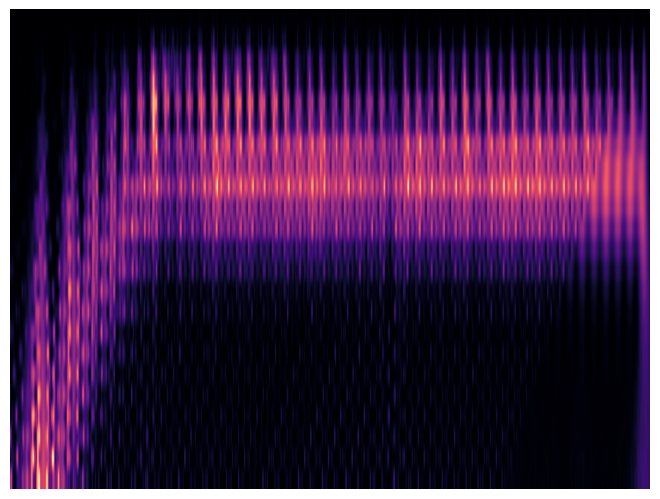

In [23]:
import random
# Which Sample to View
S = random.randint(0, len(scalogram_features))
cmap = 'magma'
# Example to view one scalogram as an image using OpenCV
temp = np.asarray(scalogram_features[S])

# Normalize the data to 0-255 for display
temp_normalized = cv2.normalize(temp, None, 0, 255, cv2.NORM_MINMAX)

# Convert to uint8
temp_normalized = temp_normalized.astype(np.uint8)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(temp_normalized, cmap, aspect='auto')
plt.show()
fig.savefig('scalo_IMAGE2.png', bbox_inches='tight', pad_inches=0, dpi=300)


## How to Inference on Unlabeled Data

In [21]:

import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class ScalogramDataset(Dataset):
    def __init__(self, features):
        self.features = features
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        
        # Expand dimensions to create a 3-channel image
        feature = np.expand_dims(feature, axis=0)
        feature = np.repeat(feature, 3, axis=0)
        
        return torch.FloatTensor(feature)

# Convert the list to a numpy array
scalogram_features = np.array(scalogram_features)

# Create dataset and dataloader
inference_dataset = ScalogramDataset(scalogram_features)
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)

def inference(model, loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for features in loader:
            features = features.to(device)
            
            outputs = model(features)
            predicted = (outputs > 0.5).float()
            
            predictions.extend(predicted.cpu().numpy())
    
    return np.array(predictions)

model.to(device)

# Run inference
predictions = inference(model, inference_loader)

# Get indices of "good" samples (where prediction is 1)
good_indices = np.where(predictions == 1)[0]

# Filter the original data to keep only "good" samples
good_samples = [squeezed_arr[i] for i in good_indices]
#bad_samples = [squeezed_arr[i] for i in range(len(squeezed_arr)) if i not in good_indices]
good_scalo_features = np.asarray([scalogram_features[i] for i in good_indices])

print(f"Total samples: {len(squeezed_arr)}")
print(f"Good samples: {len(good_samples)}")
print(f"Bad samples: {len(squeezed_arr) - len(good_samples)}")


UsageError: Line magic function `%` not found.


In [ ]:
classified_good_scalo = list()
for i in range(len(good_samples)):
    good_torque = good_samples[i]
    good_scalo = compute_scalo_spectrogram(good_torque, 'cutting segment')
    good_scalo = good_scalo[:, :window]

    # Normalizing features
    good_scalo = cv2.normalize(scalo, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_32F)

    classified_good_scalo.append(good_scalo)
print(classified_good_scalo[0].shape, len(classified_good_scalo))

/home/admin-anedunga/anaconda3/envs/Indas2/lib/python3.9/site-packages/pywt/_cwt.py:121: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)


(23, 836) 3231


## Cluster Good Samples

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans



def reshape_3d_to_2d(data):
    return data.reshape(data.shape[0], -1)

# Assuming good_scalo_features is already defined and is a list of numpy arrays
K = 6

good_features = np.asarray(classified_good_scalo)
print(good_features[0].shape, good_features.shape)  # (23, 836) (8150, 23, 836)

good_features_reshaped = good_features.reshape(good_features.shape[0], -1)
print(good_features_reshaped.shape)  # (8150, 19228)


# Perform t-SNE analysis
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(good_features_reshaped)

# Perform k-means clustering on the t-SNE results
kmeans = KMeans(n_clusters=K, random_state=42)  # Adjust the number of clusters as needed
kmeans_labels = kmeans.fit_predict(good_features_reshaped)

# Visualize the t-SNE results with clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=kmeans_labels, palette='viridis', s=100, alpha=1.0)
plt.title('K-means Clustering of t-SNE Features for Good Cutting Process')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend(title='Cluster')
plt.show()

# Determine the optimal number of clusters using the elbow method
sse = []
k_range = range(1, 12)  # Adjust the range based on your data
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tsne_results)
    sse.append(kmeans.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Sum of squared distances (SSE)')
plt.show()
